In [1]:
import torch

In [2]:
from models.transformer import Transformer, TransformerConfig

In [3]:
config_file = 'transformer_model.yaml'
from yaml import safe_load
with open(config_file) as f:
	config = safe_load(f)
config = TransformerConfig(**config['init_args'])

In [4]:
model = Transformer(config)
model.load_from_checkpoint('experiments/de-en-v1-multi30k/de-en-v1-sp-nb_6-multi30k/checkpoints/model-epoch=35-step=4000-val_loss=3.03.ckpt')

Transformer(
  (criterion): CrossEntropyLoss()
  (src_embeddings): PosNTokEmbedding(
    (token_embedding_table): Embedding(15000, 512)
    (position_embedding_table): PositionalEmbedding()
  )
  (tgt_embeddings): PosNTokEmbedding(
    (token_embedding_table): Embedding(15000, 512)
    (position_embedding_table): PositionalEmbedding()
  )
  (encoder): TransformerEncoder(
    (blocks): ModuleList(
      (0-5): 6 x TransformerEncoderBlock(
        (sa_module): MultiHeadSelfAttention(
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
          (qkv_projection): Linear(in_features=512, out_features=1536, bias=False)
          (c_proj): Linear(in_features=512, out_features=512, bias=False)
        )
        (fw_module): TransformerFeedFoward(
          (net): Sequential(
            (0): Linear(in_features=512, out_features=2048, bias=True)
            (1): GELU(approximate='tanh')
            (2): Linear(in_features=2048, out_f

In [5]:
from datasets.translate import TranslationDataset, TranslationDatasetConfig

config = TranslationDatasetConfig(
	max_seq_len= 512,
    src_file= 'data/multi30k/train.de',
    src_sp_model_file= 'data/multi30k/m_en_de.model',
    tgt_file= 'data/multi30k/train.en',
    tgt_sp_model_file= 'data/multi30k/m_en_de.model'
)

dataset = TranslationDataset(config)

Reading input files...


In [6]:
dl = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=TranslationDataset.get_collate_function())

In [7]:
batch = next(iter(dl))

In [8]:
batch

TransformerInputBatch(x_src=tensor([[    1,   156,   693,  1656,   251,   705,   162,   734,    18,   116,
           839, 14900, 14928,  1252, 14905,  2068,   285, 14901, 14917,     2]]), x_tgt=tensor([[    1,   161,   217, 14930,  5517,    21,  2779,   132,   459,   114,
           134,  1850,  6029]]), x_src_mask=tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True]]), x_tgt_mask=tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True]]), y_tgt=tensor([[  217, 14930,  5517,    21,  2779,   132,   459,   114,   134,  1850,
          6029, 14917,     2]]))

In [9]:
output = model(batch.x_src, batch.x_tgt, batch.x_src_mask, batch.x_tgt_mask)
output.shape

torch.Size([1, 13, 15000])

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

def plot_attention_weights(attention_weights: dict, head: int = 0):
	n_columns = 4
	n_rows = len(attention_weights) // n_columns + 1
	fig_size = (n_columns * 5, n_rows * 4)
	fig, axs = plt.subplots(n_rows, n_columns, figsize=fig_size)
	for i, (name, weights) in enumerate(attention_weights.items()):
		ax = axs[i // n_columns, i % n_columns]
		ax.set_title(name)
		sns.heatmap(weights[0, head].detach().numpy(), ax=ax)
	fig.tight_layout()
	fig.savefig(f'nmt_{head}.png')


[None, None, None]

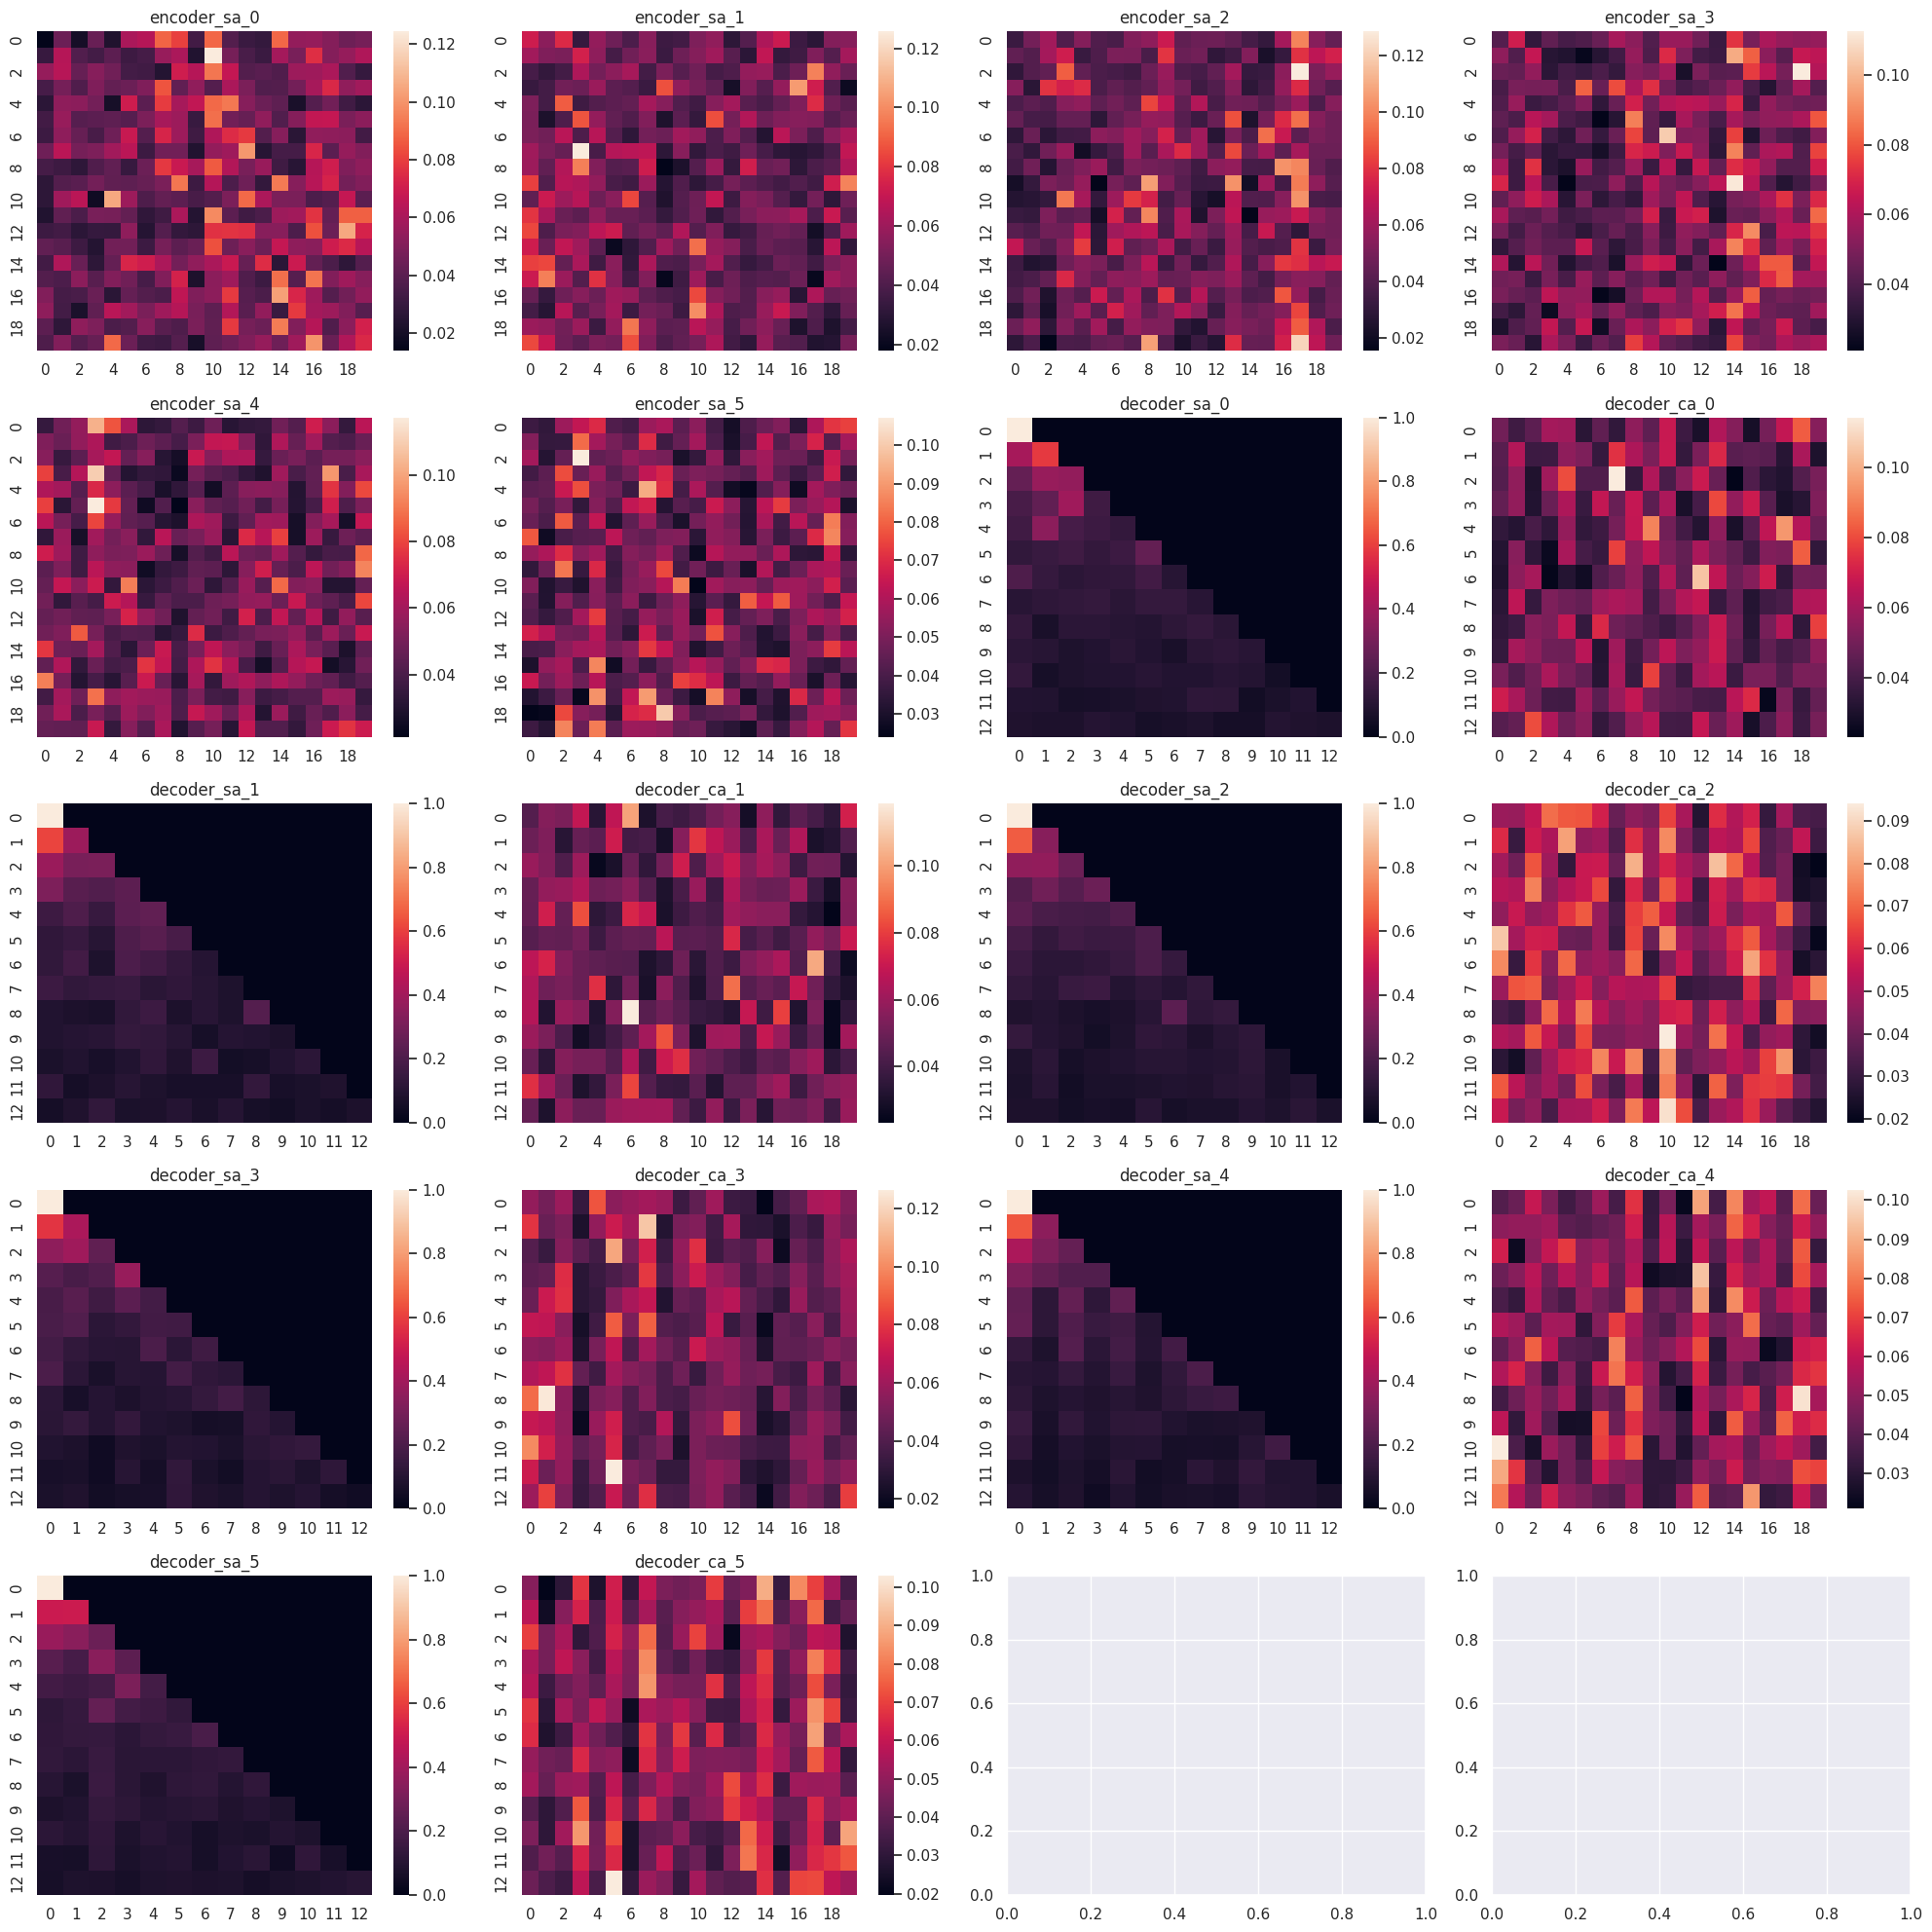

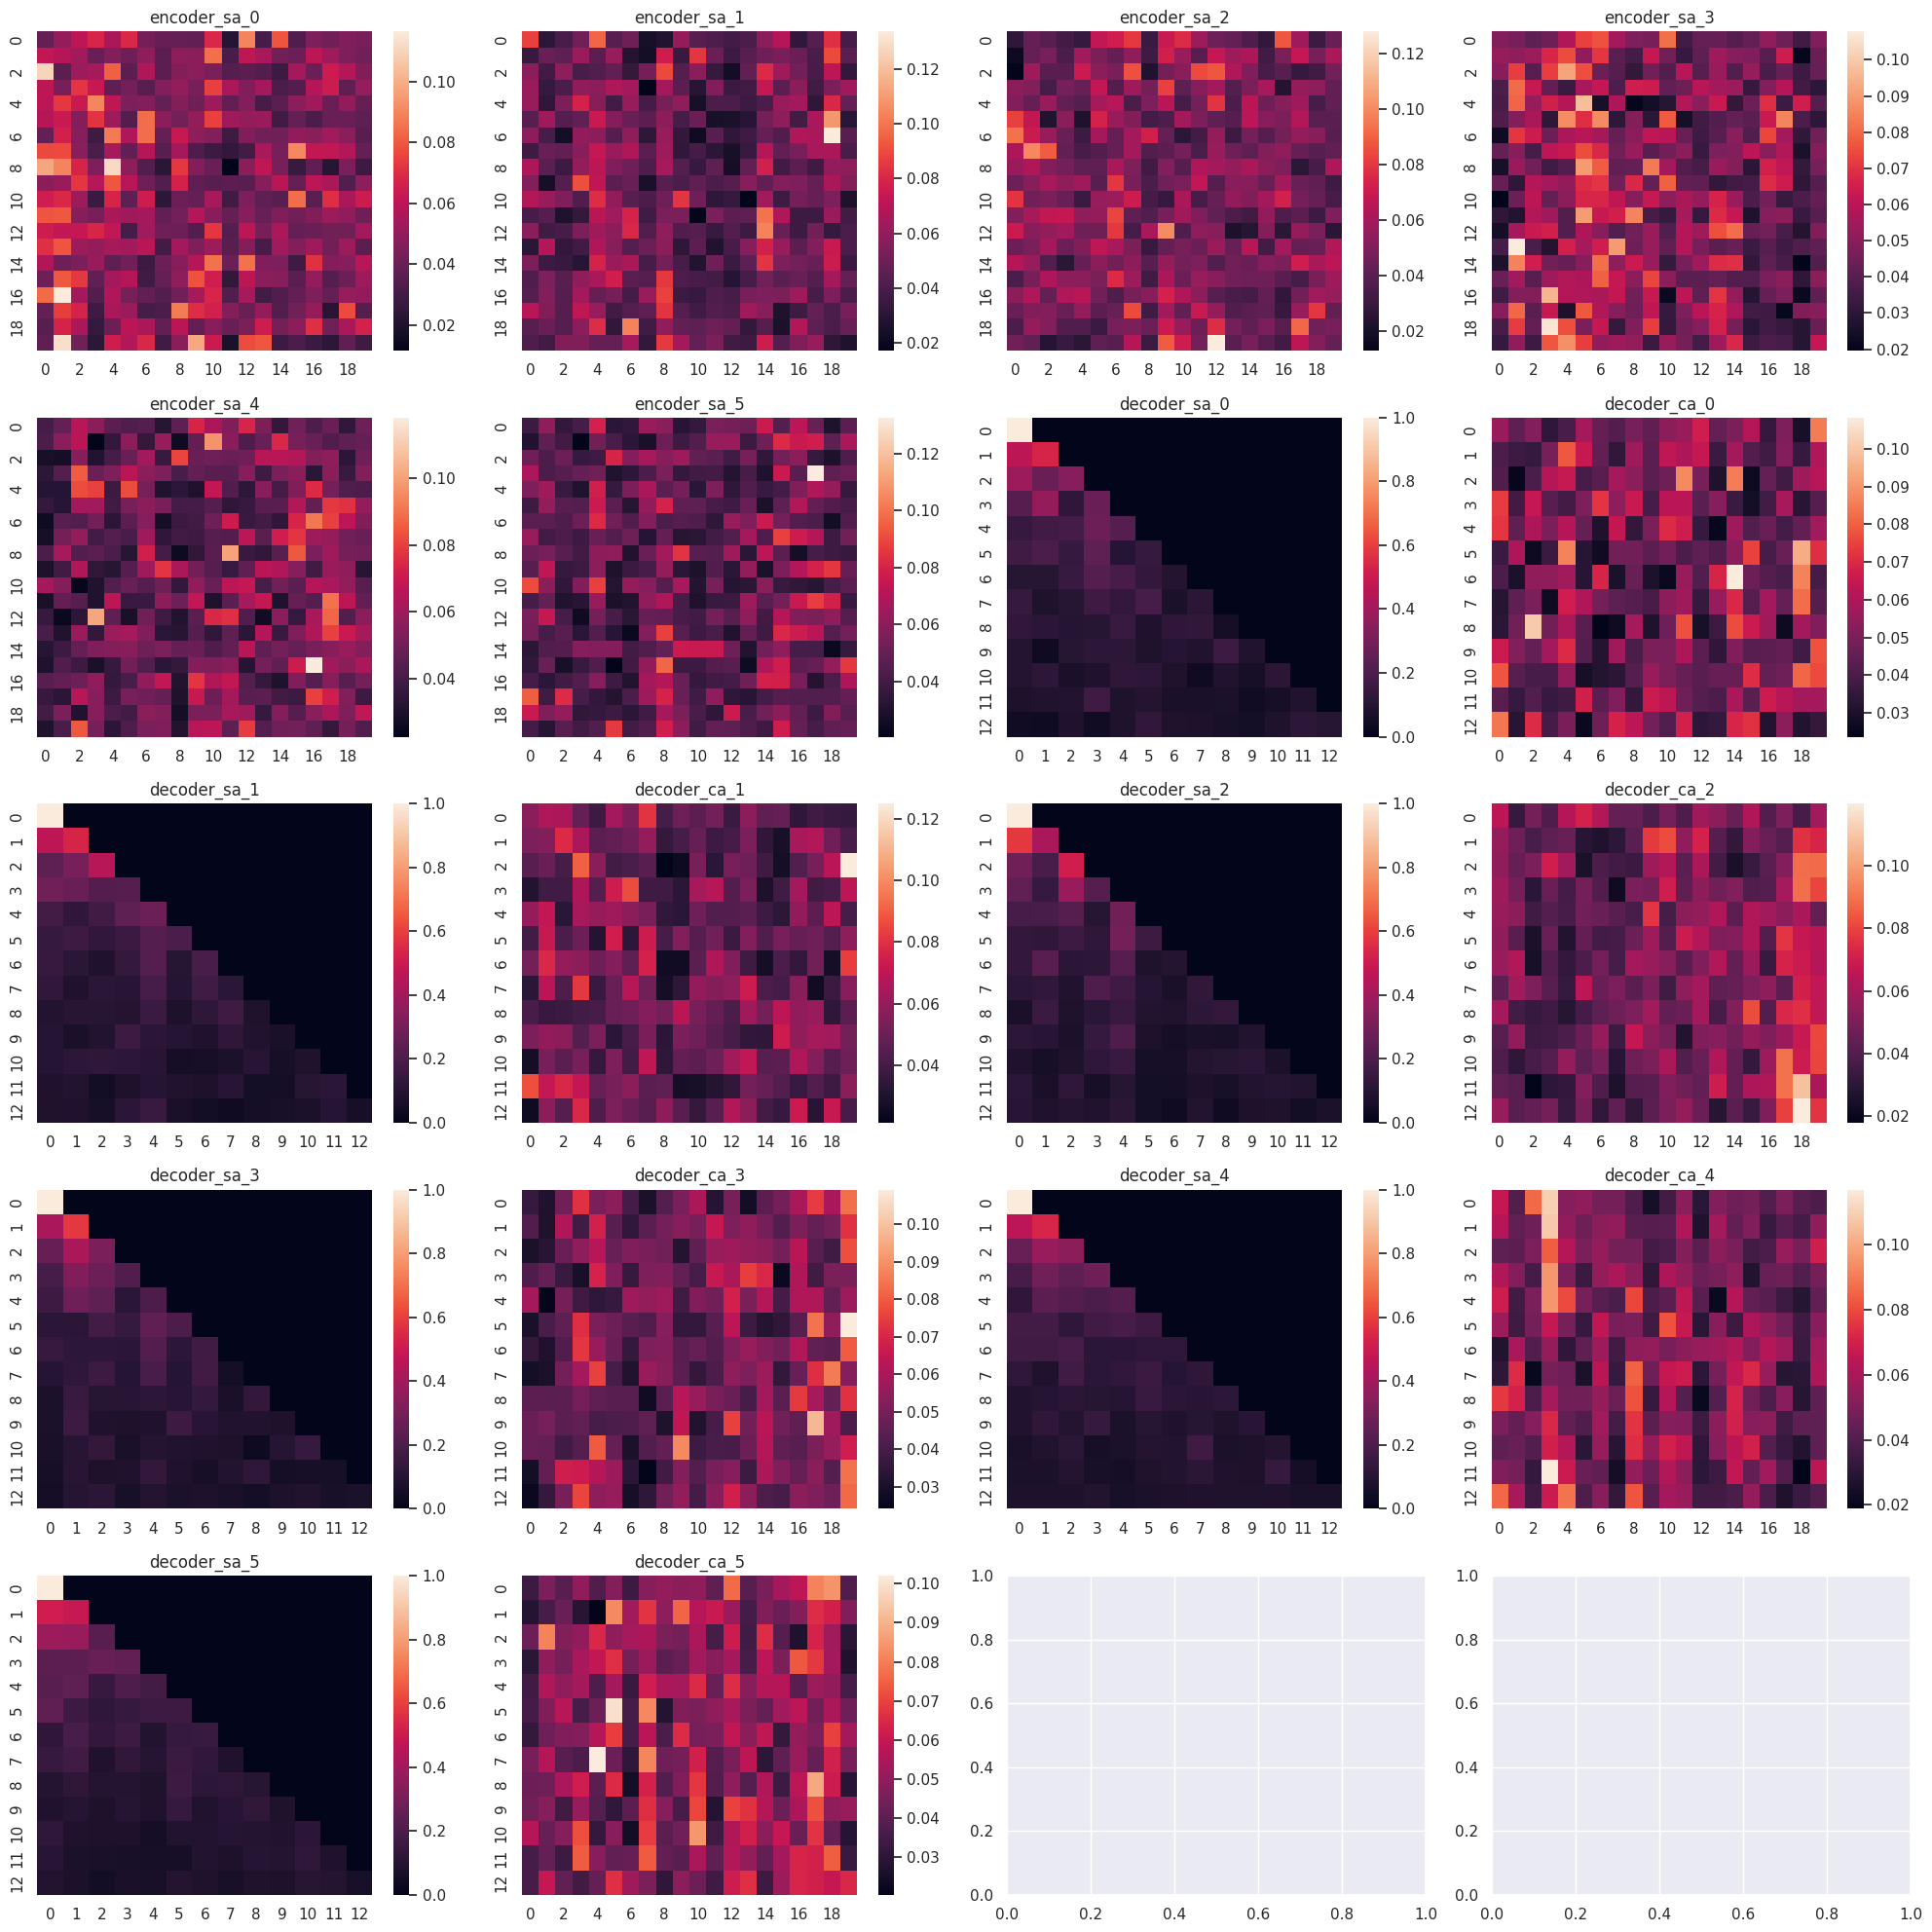

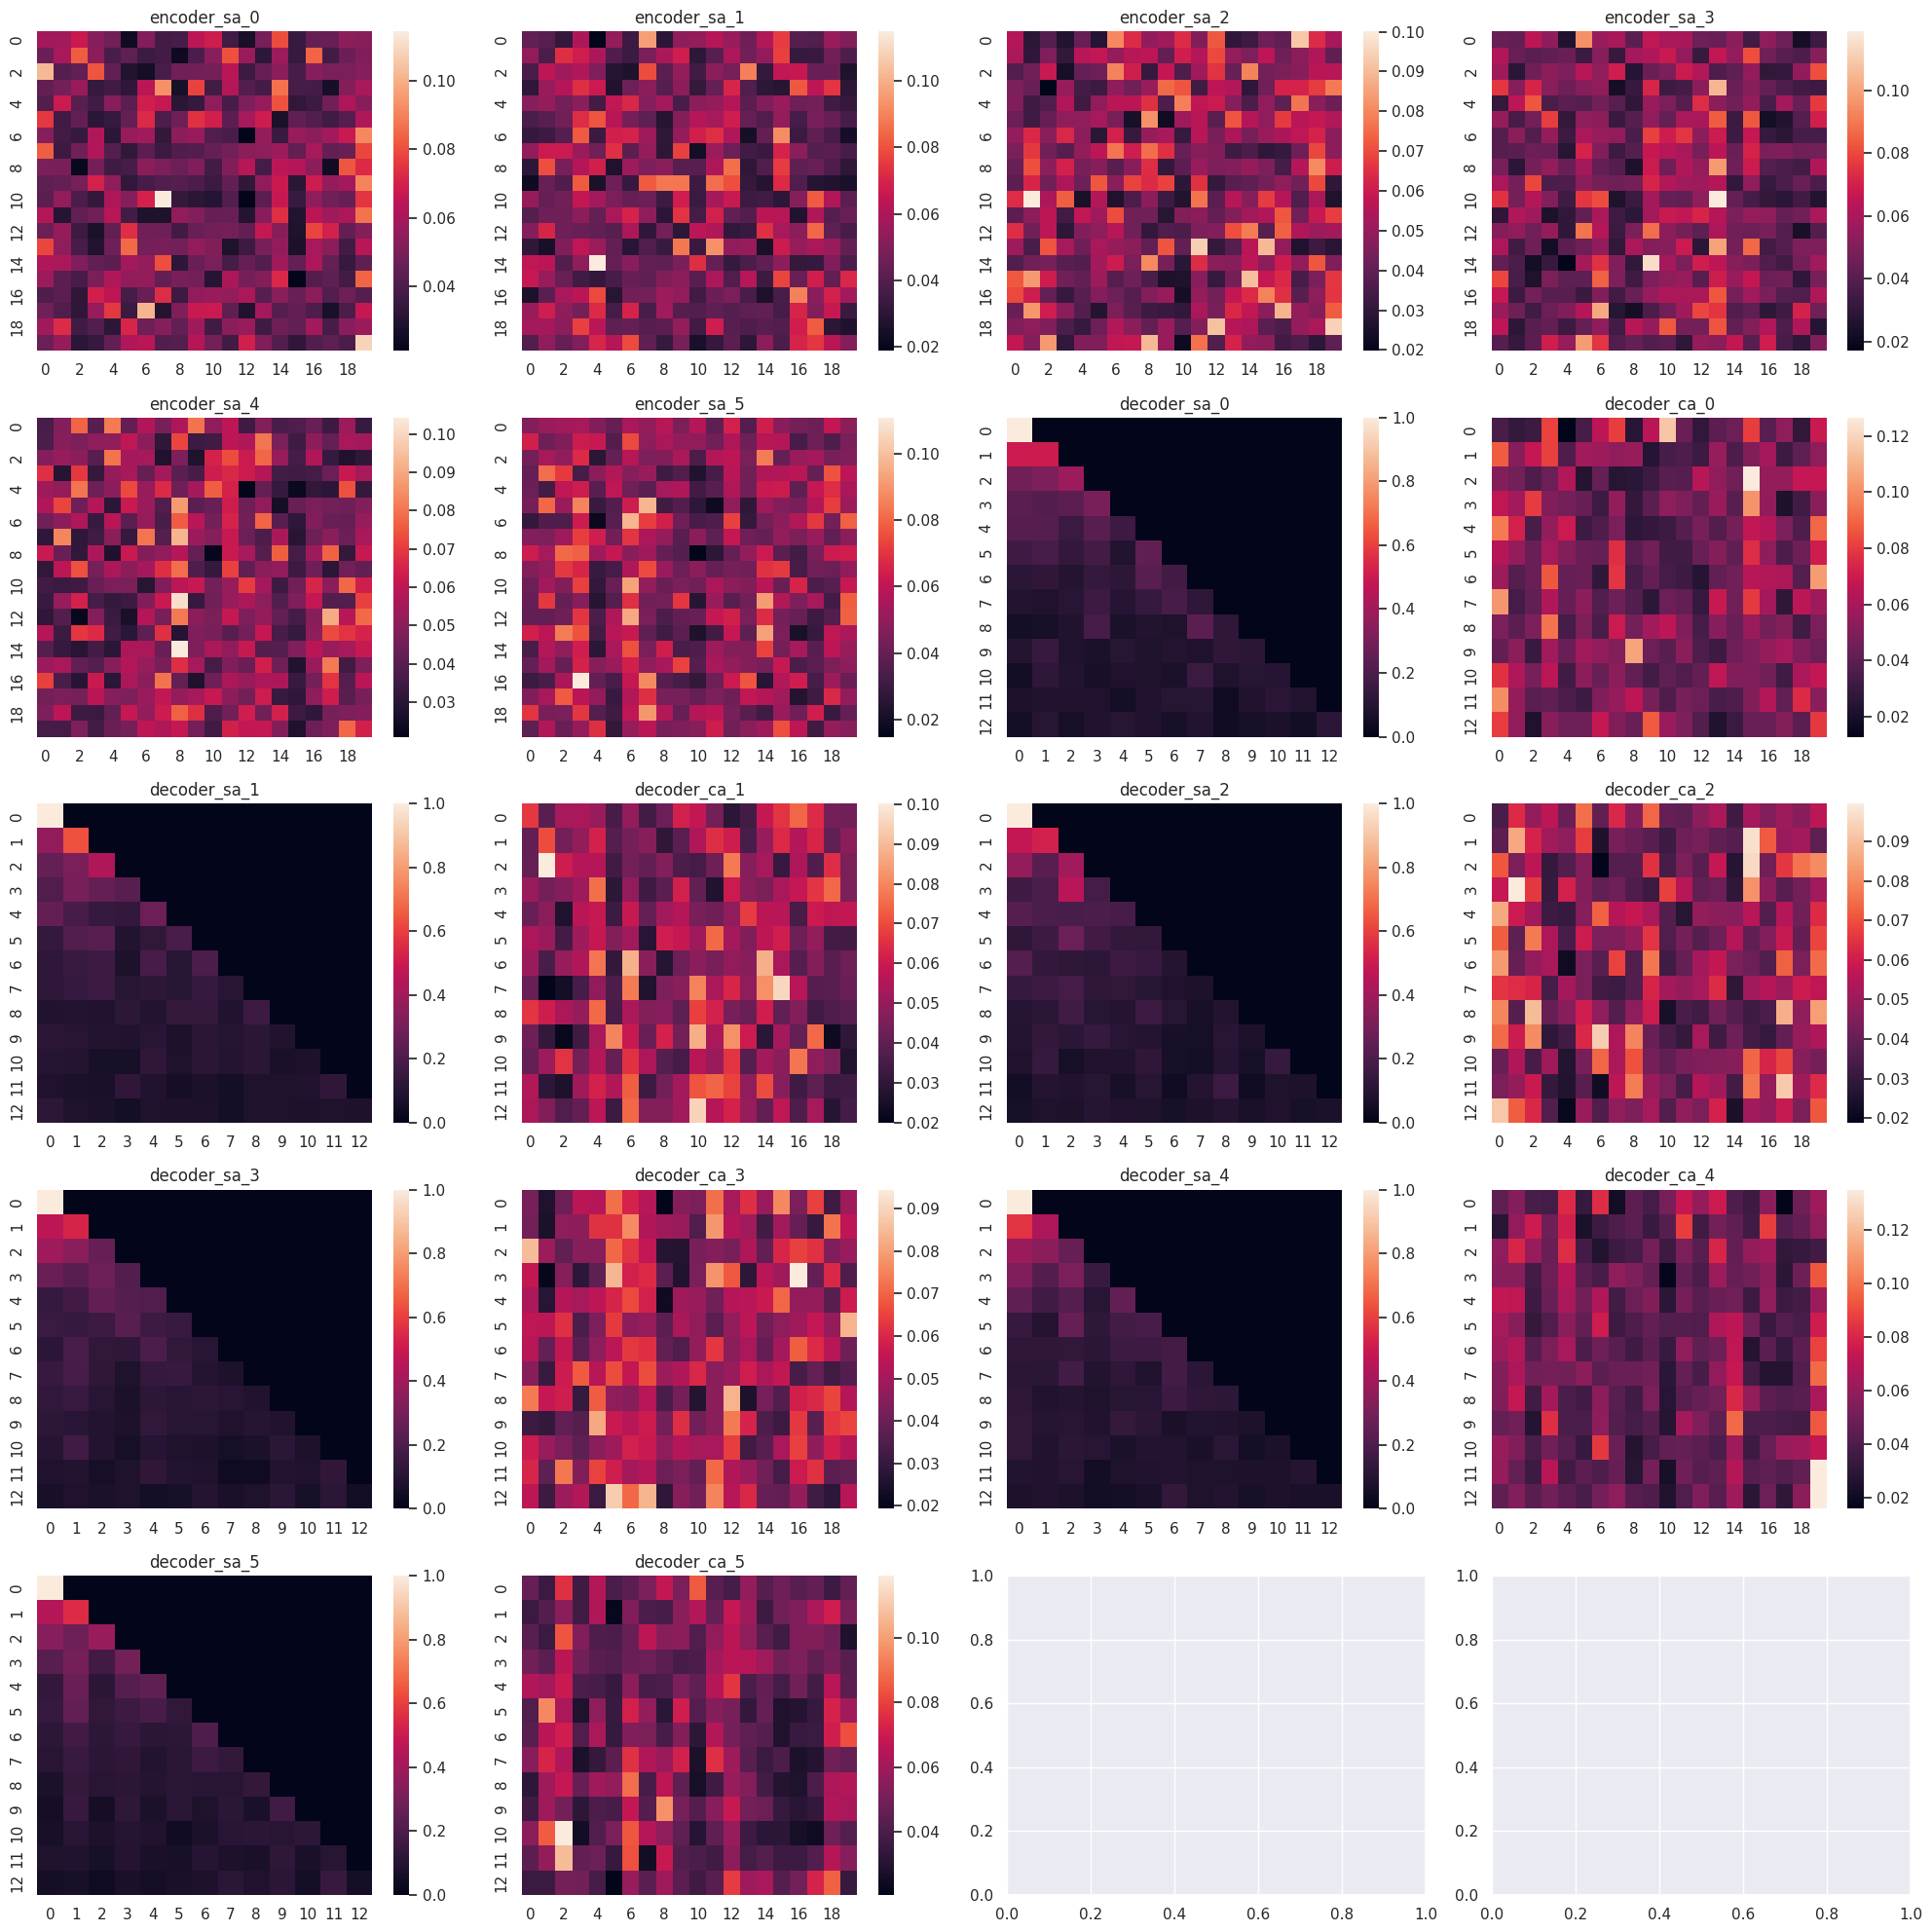

In [12]:
[plot_attention_weights(model.attention_weights, i) for i in range(1, 4)]